In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [4]:
import itertools
import os
import shutil
import random 
import glob
import warnings
# warnings.simplefilter(action='ignore',category='FutureWarning')

In [5]:
train_path = '/content/drive/MyDrive/cat_vs_dog_dataset/train'
test_path = '/content/drive/MyDrive/cat_vs_dog_dataset/test'
valid_path = '/content/drive/MyDrive/cat_vs_dog_dataset/valid'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size = (224,224), classes = ['cat','dog'], batch_size = 10)

valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size = (224,224), classes = ['cat','dog'], batch_size = 10)

test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size = (224,224), classes = ['cat','dog'], batch_size = 10, shuffle = False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [8]:
imgs, labels = next(train_batches)

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(imgs)
print(labels)

In [10]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 5s 0us/step


In [11]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params':non_trainable_params,'trainable_params':trainable_params}

In [13]:
params = count_params(vgg16_model)
assert params['non_trainable_params']==0
assert params['trainable_params'] == 138357544

In [14]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [16]:
params = count_params(model)
assert params['non_trainable_params']==0
assert params['trainable_params'] == 134260544

In [17]:
for layer in model.layers:
    layer.trainable =False

In [18]:
model.add(Dense(units=2, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [20]:
params = count_params(model)
assert params['non_trainable_params']== 134260544
assert params['trainable_params'] == 8194

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 848s - loss: 0.2225 - accuracy: 0.9110 - val_loss: 0.1147 - val_accuracy: 0.9650 - 848s/epoch - 8s/step
Epoch 2/5
100/100 - 902s - loss: 0.0886 - accuracy: 0.9670 - val_loss: 0.0706 - val_accuracy: 0.9700 - 902s/epoch - 9s/step
Epoch 3/5
100/100 - 813s - loss: 0.0594 - accuracy: 0.9800 - val_loss: 0.0758 - val_accuracy: 0.9700 - 813s/epoch - 8s/step
Epoch 4/5
100/100 - 815s - loss: 0.0448 - accuracy: 0.9880 - val_loss: 0.0570 - val_accuracy: 0.9800 - 815s/epoch - 8s/step
Epoch 5/5
100/100 - 876s - loss: 0.0341 - accuracy: 0.9910 - val_loss: 0.0656 - val_accuracy: 0.9800 - 876s/epoch - 9s/step


In [23]:
predictions = model.predict(x=test_batches, verbose=0)

In [24]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black' )
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [27]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[49  1]
 [ 4 46]]


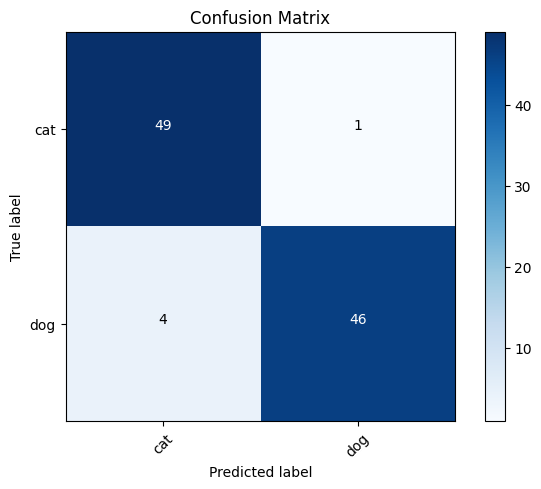

In [28]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In VGG16 model, It is already trained for cat vs dog dataset by default by their developer.
But, now will use this fine tuned model for the dataset which is not already pretrained in vgg model.




Now, we are going to do more fine tuning of the model using the MobileNet Image classification model. 
Link:
https://colab.research.google.com/drive/1ezLtQwZOmVm73yPUAl3Wrv_XkVn-QZV1?usp=sharing
